In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
imNum = 1   # счётчик для названий картинок
impath = 'trash_img'    # путь к папке, в которой будут сохраняться картинки
#switching latex fonts
plt.rcParams.update({
    "text.usetex" : True,
    "font.family" : "serif",
    "font.serif" : "Computer Modern",
    "text.latex.preamble" : r'\usepackage{amsmath} \usepackage{mathtext} \usepackage[english, russian]{babel}'
})
plt.rcParams.update({
    "figure.figsize": (8, 6),
    'figure.dpi': 200
})

# необходимые функции

def err_pres_formatter(value, error):
    """Rounds value and it's error according to scientific conventions"""
    first_digit = (np.array(error/10**np.floor(np.log10(error)), dtype="int"))
    first_digit_position = np.array(np.floor(np.log10(error)), dtype="int")
    ndigits = 1
    if first_digit == 1:
        ndigits += 1
    power = np.log10(abs(value))
    if abs(power//3) >= 1:
        power = 3*int(power//3)
        value /= 10**power
        error /= 10**power
        digit_number = -first_digit_position + ndigits+power-1
        if digit_number <= 0:
            return f"({round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)})$\cdot 10^{{{power}}}$"
        return f"({round(value, digit_number)} \u00B1 {round(error, digit_number)})$\cdot 10^{{{power}}}$"
    digit_number = -first_digit_position + ndigits-1
    if digit_number <= 0:
        return f"{round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)}"
    return f"{round(value, digit_number)} \u00B1 {round(error, digit_number)}"


def lower_upper_limits(domain, fun, popt, pcov, nsigma=1):
    '''Вычисляет минимальные и максимальные значения функции 
    при заданных парамерах и стандартных отклонениях
    в пределах nsigma*стандартное отклонение
    Возвращает:
    minA :(np.array) - массив минимальных значений
    maxA :(np.array) - массив максимальных значений'''
    err = np.sqrt(np.diag(pcov))
    corr = pcov /np.expand_dims(err, 1) / np.expand_dims(err, 0)
    deviations = np.eye(popt.size)*np.expand_dims(err, 1)  
    df = np.expand_dims(fun(domain, *popt), 1) - fun(np.expand_dims(domain, 1), *(np.expand_dims(popt, 1)+np.eye(popt.size)*np.expand_dims(err, 1)))
    dfmatrixes = np.expand_dims(df, 1)*np.expand_dims(df, 2) * np.expand_dims(corr, 0)
    sigm_f = np.sqrt(np.sum(dfmatrixes, axis=(1, 2)))
    return (fun(domain, *popt)-nsigma*sigm_f, fun(domain, *popt)+nsigma*sigm_f)

def plot_approx(x, y, f, par_names_str, fun_name, yerr=None, visApproxError=True, p0=None):
    if yerr is not None:
        popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=False, p0=p0)
    else:
        popt, pcov = curve_fit(f, x, y, p0=p0)
    err = np.sqrt(np.diag(pcov))
    for v, er in zip(popt, err):
        print(v,'+-',er)
    approx_label = f"аппроксимация функцией {fun_name}"
    par_names = [x.split(', ') for x in par_names_str.strip().split("\n")]
    for i in range(len(par_names)):
        t = par_names[i]
        if len(t) == 2:
            name, units = t
        else:
            name, units = *t, ''
        approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])} {units}"
    teorPoints = 50     
    intent = 0.05   # отступ по бокам от обласи экспериментальных данных
    a, b = x.min(), x.max()
    X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
    plt.plot(X, f(X, *popt), 'r', label=approx_label)
    if visApproxError and (pcov != np.inf).all():
        nsigma = 2
        minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
        plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")


In [6]:
#Тестовые данные 1
# df = pd.read_excel("measurements.ods", engine="odf") 
# x = df.iloc[:, 0].dropna()
# y = df.iloc[:, 1].dropna()
# xerr = np.ones_like(x)*0.01
# yerr = np.ones_like(x)*0.01
# df.head()

#тестовые данные 2. Затухание

df = pd.read_excel("measurements.ods", engine="odf") 
x = df.iloc[:, 3].dropna()
y = df.iloc[:, 4].dropna()
xerr = np.ones_like(x)*1
yerr = np.ones_like(x)*0.1
df.head()

,"Q, мВт","R, $\Omega$",калоримерт,"t, c","H, см",первое тело,"R, om","t, c.1",второе тело,"R, om.1","t, c.2",третье тело
0,0.000249,16.735029,NaN,0.0,30.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.446031,16.812200,NaN,15.0,29.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9.670230,16.853135,NaN,25.0,29.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19.561403,16.926607,NaN,35.0,29.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32.830711,17.030702,NaN,45.0,29.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# параметры построения графика и аппроксмации
# пользовательские параметры. Переменные x, y, xerr, yerr дожны содержать данные
''' также необходимо изменить
название графика, 
название функции ,
набор параметров с размерностями через запятую '''
visApproxError = True   # рисовать ли область ошибки аппроксимации
hasErrors = True
# visApproxError*=hasErrors   # нельзя рисовать ошибки, если их нет)
par_names_str = r'''
k, $\frac{кг}{см}$
b, кг
'''
xname, xunit = r"$x$", "см"
yname, yunit = r"$y$", "кг"
# function to approximate
fun_name = r"$f(x) = kx + b$"
def f(x, k, b):
    return b + k * x
# конец пользовательских параметров

5061.632346853245 +- 7128128.799588944
-5031.59977104134 +- 7128128.758004449
-530940.3227311438 +- 752130646.5238848


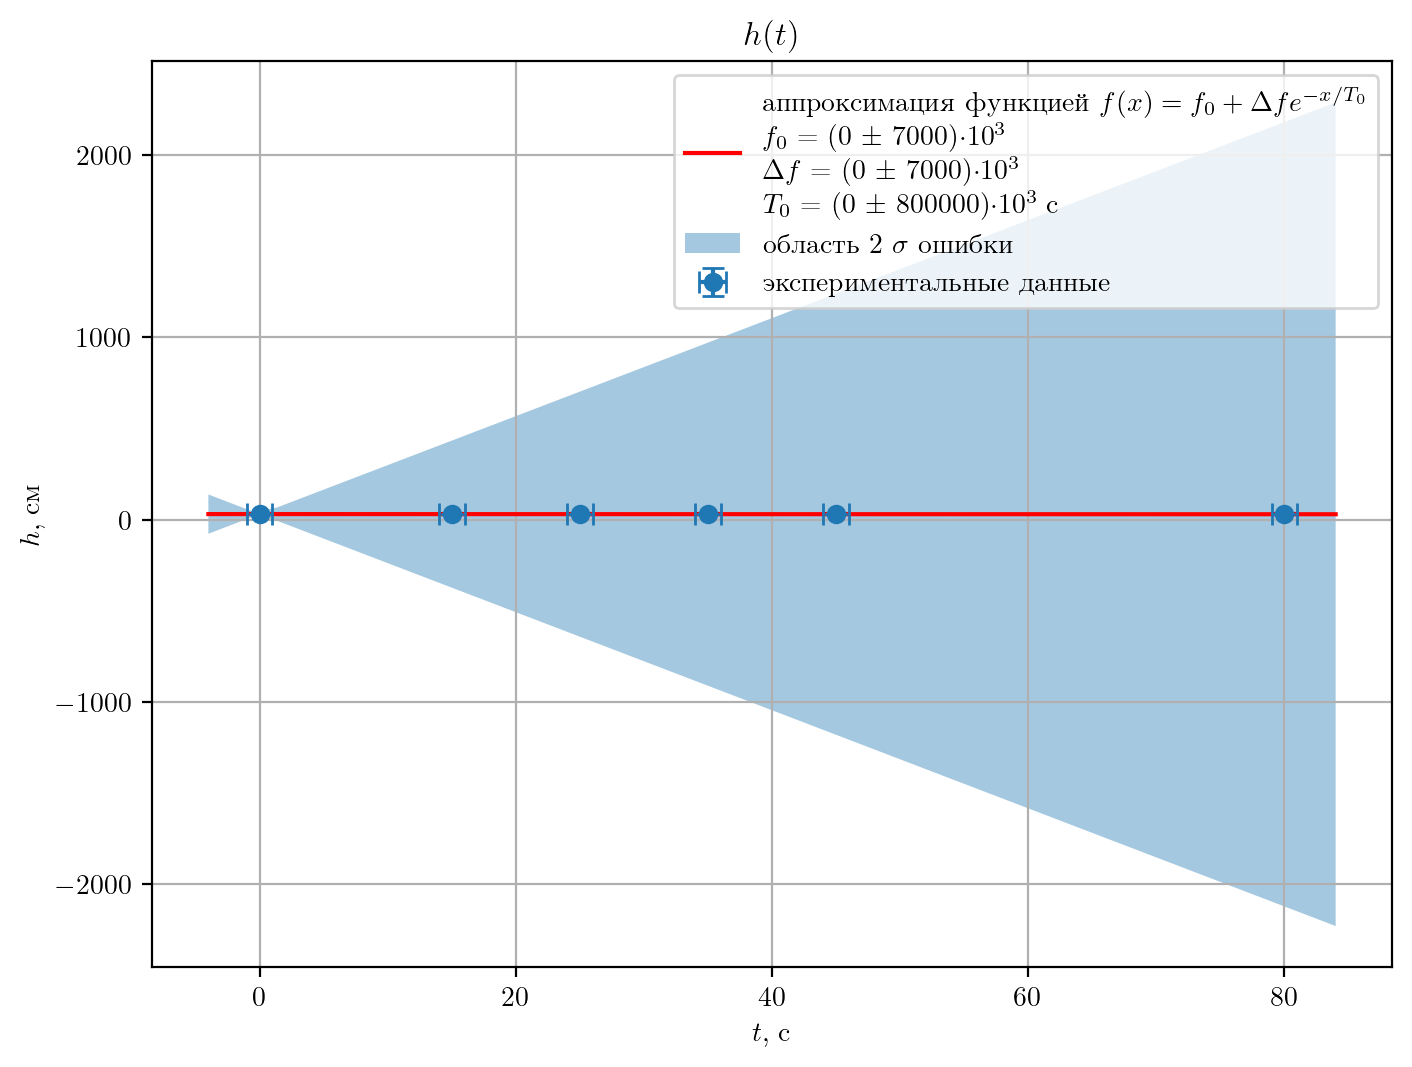

In [14]:
# построение графика

# # опциональная загрузка данных разных измерений
# N = 0 # номер измерения
# stride = 3
# x = df.iloc[:, stride*N+1].dropna()
# y = df.iloc[:, stride*N+0].dropna()
# xerr = np.ones_like(x)*0.1
# yerr = np.ones_like(x)*1
# xname, xunit = x.name.split(', ')
# yname, yunit = y.name.split(', ')

# аппроксимация
plot_approx(x, y, f, par_names_str, fun_name, yerr=yerr, visApproxError=True, p0=None)

# экспериментальные точки
if hasErrors:
    plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)
else:
    plt.plot(x, y, "o", label="экспериментальные данные")
plt.grid(True, which='minor', linewidth=0.2)
plt.grid(True, which='major')
plt.xlabel(fr"{xname}, {xunit}")
plt.ylabel(fr"{yname}, {yunit}")
plt.title(fr"{yname}({xname})")
plt.legend()

if not os.path.exists(impath):
    os.makedirs(impath)
plt.savefig(os.path.join(impath, f"templ{imNum}.png"), dpi=300)
imNum+=1

In [11]:
# шаблон аппроксимации экспонентой
# пользовательские параметры. Переменные x, y, xerr, yerr дожны содержать данные
''' также необходимо изменить
название графика, 
название функции ,
набор параметров с размерностями через запятую '''
visApproxError = True   # рисовать ли область ошибки аппроксимации
hasErrors = True
# visApproxError*=hasErrors   # нельзя рисовать ошибки, если их нет)
par_names_str = r'''
$f_0$
$\Delta f$
$T_0$, c
'''
xname, xunit = r"$t$", "с"
yname, yunit = r"$h$", "см"
# function to approximate
fun_name = r"$f(x) = f_0 + \Delta f e^{-x/T_0}$"
def f(x, f_0, df, T0):
    return f_0 + df*np.exp(-x/T0)
p0=[30, 0.2, 8]
# конец пользовательских параметров